## Imports

In [2]:
import cv2
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, BatchNormalization, GlobalAveragePooling2D, ReLU
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from dotenv import load_dotenv

## Data Loading

In [3]:
class LoadData:
    """
    LoadData class
    """
    def __init__(self, base_path):
        self.base_path = base_path

    def load_data(self, height, width):
      """
      
      """
      x = []
      y = []

      
      for class_number in range(10):
        class_number_str = 'c' + str(class_number)
        path = os.path.join(self.base_path, 'imgs/data', class_number_str, '*.jpg')
        file_paths = glob.glob(path)  # Gets all file names matching given path.
        sub_x = []
        sub_y = []
        for file_path in file_paths:
            sub_x.append(file_path)
            temp = np.zeros(10)
            temp[class_number] = 1
            sub_y.append(temp)
        self.shuffle_data(sub_x)
        x.append(sub_x)
        y.append(sub_y)
      print("Saved all image paths.")
      return x, y

    def shuffle_data(self, x):
      np.random.shuffle(x)

In [9]:
HEIGHT = 128
WIDTH = 128

load_dotenv()
PATH = os.getenv('PATH_TO_DATA')
x, y = LoadData(PATH).load_data(HEIGHT, WIDTH)

Saved all image paths.


## Data Preprocessing


In [10]:
class PreProcessing:
  """
  Goes through all images, returns preprocessed tensor.
  """

  def __init__(self):
    self.kernel = np.array([[-1, -1, -1],
                  [-1, 8,-1],
                  [-1, -1, -1]])
  
  def get_colour_type(self, img_path):
    image = cv2.imread(img_path)
    if len(image.shape) == 3: return 3
    return 1

  def preprocess_image(self, img_path, height, width, training):
    """
    Function takes the path to the image and applys the preprocessing.
    """

    color_type = self.get_colour_type(img_path)

    if color_type == 1:
        img = cv2.imread(img_path, 0)
        img_gray = cv2.threshold(img,0,255,cv2.THRESH_TRUNC+cv2.THRESH_OTSU) 
        image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=self.kernel)

    elif color_type == 3:
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.threshold(img_gray,0,255,cv2.THRESH_TRUNC+cv2.THRESH_OTSU)
        image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=self.kernel)
        image_sharp = cv2.cvtColor(image_sharp, cv2.COLOR_BGR2GRAY)
    

    combined = cv2.add(image_sharp, img_gray[1])
    dst = cv2.resize(combined, (width, height))
    img = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

    if training:
      img = self.random_erasing(img)
    return img

  def random_erasing(self, image, probability=0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
    """
    Function performs random erasing
    """
    if np.random.uniform(0, 1) > probability:
        return image
    area = image.shape[0] * image.shape[1]
    for _ in range(100):
        target_area = np.random.uniform(sl, sh) * area
        aspect_ratio = np.random.uniform(r1, 1/r1)

        h = int(round(np.sqrt(target_area * aspect_ratio)))
        w = int(round(np.sqrt(target_area / aspect_ratio)))

        if w < image.shape[1] and h < image.shape[0]:
            x1 = np.random.randint(0, image.shape[0] - h)
            y1 = np.random.randint(0, image.shape[1] - w)
            if image.shape[2] == 3:
                image[x1:x1+h, y1:y1+w, 0] = mean[0]
                image[x1:x1+h, y1:y1+w, 1] = mean[1]
                image[x1:x1+h, y1:y1+w, 2] = mean[2]
            else:
                image[x1:x1+h, y1:y1+w, 0] = mean[0]
            return image
    return image
  
  def split_data(self, x, y, height, width):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    split_points = self.percent_indexes(x)
    for class_num, (xi, yi) in enumerate(zip(x, y)):
      print(f"Preprocessing class: {class_num}.")
      for image_number, (image_path, out) in enumerate(zip(xi, yi)):
        if image_number < split_points[class_num]:
          
          image = self.preprocess_image(image_path, height, width, False)
          x_test.append(image)
          y_test.append(out)
          
        else:
          image = self.preprocess_image(image_path, height, width, True)
          x_train.append(image)
          y_train.append(out)
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
    

  def percent_indexes(self, x):
    split_points = []
    for xi in x:
      number_of_images = len(xi)
      split_point = int(number_of_images*0.2)
      split_points.append(split_point)
    return split_points

In [11]:
p = PreProcessing()
x_train, y_train, x_test, y_test = p.split_data(x, y, HEIGHT, WIDTH)

Preprocessing class: 0.
Preprocessing class: 1.
Preprocessing class: 2.
Preprocessing class: 3.
Preprocessing class: 4.
Preprocessing class: 5.
Preprocessing class: 6.
Preprocessing class: 7.
Preprocessing class: 8.
Preprocessing class: 9.


## Model

In [52]:
class VGG16:

  def __init__(self, input_shape=(None, None, 3)):
    self.vgg16 = self.create_model(input_shape)
    self.vgg16.summary()

  def create_model(self, input_shape):
    model = Sequential([
      Input(shape=input_shape),                               # Block 1
      Conv2D(32, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(32, (3, 3), padding='same'),
      BatchNormalization(axis = 3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),                      # Block 2
      Conv2D(64, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(64, (3, 3), padding='same'),
      BatchNormalization(axis = 3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),                      # Block 3
      Conv2D(128, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(128, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(128, (3, 3), padding='same'),
      BatchNormalization(axis = 3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),                      # Block 4  
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(axis = 3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),                      # Block 5  
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(axis = 3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),                      # Fully Connected Layers
      GlobalAveragePooling2D(),
      Dense(512, activation='relu'),
      Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

  def fit_model(self, model, x_train, y_train, epochs, batch_size, verbose):
    model.fit(x_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size)
    
  def evaluate_model(self, model, x_test, y_test, batch_size):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'\nTest lost: {test_loss} -- Test accuracy: {test_acc}')

    y_pred = model.predict(x_test, batch_size=batch_size, verbose=1)
    

    
    y_pred=np.argmax(y_pred, axis=1)
    y_test=np.argmax(y_test, axis=1)
    
    # Names of possible classes
    class_names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
    # Generate confusion matrix and display using sklearn
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
    # Increases the size of the displayed confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, values_format='')
    print(classification_report(y_test, y_pred, target_names=class_names))

In [53]:
EPOCHS = 10
VERBOSE = 1
BATCH_SIZE = 16


model = VGG16((HEIGHT, WIDTH, 3))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_221 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_221 (Ba  (None, 128, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 re_lu_221 (ReLU)            (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_221 (MaxPooli  (None, 128, 128, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_222 (Conv2D)         (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_222 (Ba  (None, 128, 128, 32)   

Epoch 1/10
1122/1122 [==============================] - 28s 24ms/step - loss: 1.6135 - accuracy: 0.4125
Epoch 2/10
1122/1122 [==============================] - 26s 23ms/step - loss: 0.6418 - accuracy: 0.7809
Epoch 3/10
1122/1122 [==============================] - 26s 23ms/step - loss: 0.3912 - accuracy: 0.8676
Epoch 4/10
1122/1122 [==============================] - 26s 23ms/step - loss: 0.2728 - accuracy: 0.9075
Epoch 5/10
1122/1122 [==============================] - 26s 23ms/step - loss: 0.2033 - accuracy: 0.9322
Epoch 6/10
1122/1122 [==============================] - 26s 23ms/step - loss: 0.1472 - accuracy: 0.9484
Epoch 7/10
1122/1122 [==============================] - 26s 23ms/step - loss: 0.1242 - accuracy: 0.9570
Epoch 8/10
1122/1122 [==============================] - 26s 23ms/step - loss: 0.1020 - accuracy: 0.9648
Epoch 9/10
1122/1122 [==============================] - 26s 23ms/step - loss: 0.0871 - accuracy: 0.9712
Epoch 10/10
141/141 [==============================] - 2s 14ms/s

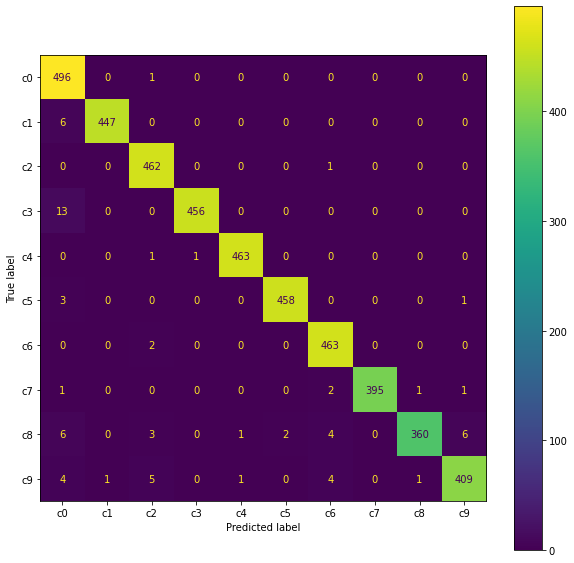

In [54]:
model.fit_model(model.vgg16_1, x_train, y_train, EPOCHS, BATCH_SIZE, VERBOSE)
model.evaluate_model(model.vgg16_1, x_test, y_test, BATCH_SIZE)

Epoch 1/10
1122/1122 [==============================] - 30s 26ms/step - loss: 1.5201 - accuracy: 0.4293
Epoch 2/10
1122/1122 [==============================] - 29s 26ms/step - loss: 0.5743 - accuracy: 0.8033
Epoch 3/10
1122/1122 [==============================] - 30s 27ms/step - loss: 0.3144 - accuracy: 0.8932
Epoch 4/10
1122/1122 [==============================] - 30s 27ms/step - loss: 0.2066 - accuracy: 0.9309
Epoch 5/10
1122/1122 [==============================] - 29s 26ms/step - loss: 0.1578 - accuracy: 0.9454
Epoch 6/10
1122/1122 [==============================] - 30s 26ms/step - loss: 0.1253 - accuracy: 0.9571
Epoch 7/10
1122/1122 [==============================] - 30s 27ms/step - loss: 0.1020 - accuracy: 0.9651
Epoch 8/10
1122/1122 [==============================] - 30s 27ms/step - loss: 0.0890 - accuracy: 0.9697
Epoch 9/10
1122/1122 [==============================] - 30s 27ms/step - loss: 0.0772 - accuracy: 0.9736
Epoch 10/10
141/141 [==============================] - 2s 15ms/s

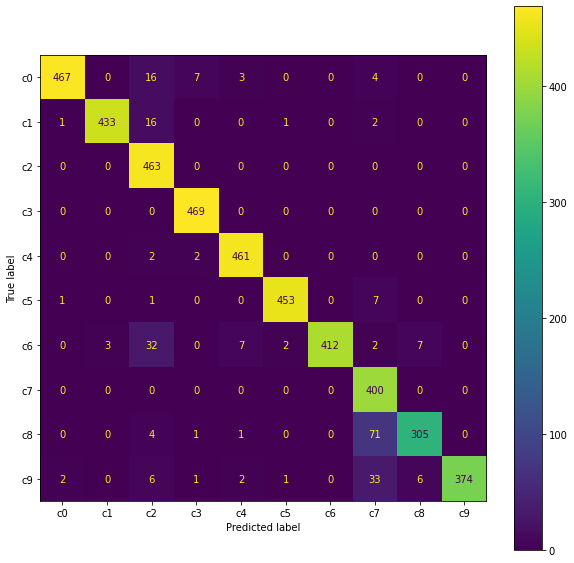

In [55]:
model.fit_model(model.vgg16_2, x_train, y_train, EPOCHS, BATCH_SIZE, VERBOSE)
model.evaluate_model(model.vgg16_2, x_test, y_test, BATCH_SIZE)

Epoch 1/10
1122/1122 [==============================] - 28s 25ms/step - loss: 1.0284 - accuracy: 0.6535
Epoch 2/10
1122/1122 [==============================] - 27s 24ms/step - loss: 0.2461 - accuracy: 0.9210
Epoch 3/10
1122/1122 [==============================] - 28s 25ms/step - loss: 0.1307 - accuracy: 0.9586
Epoch 4/10
1122/1122 [==============================] - 27s 24ms/step - loss: 0.0852 - accuracy: 0.9728
Epoch 5/10
1122/1122 [==============================] - 27s 24ms/step - loss: 0.0759 - accuracy: 0.9745
Epoch 6/10
1122/1122 [==============================] - 27s 24ms/step - loss: 0.0690 - accuracy: 0.9763
Epoch 7/10
1122/1122 [==============================] - 27s 24ms/step - loss: 0.0491 - accuracy: 0.9851
Epoch 8/10
1122/1122 [==============================] - 27s 24ms/step - loss: 0.0485 - accuracy: 0.9845
Epoch 9/10
1122/1122 [==============================] - 27s 24ms/step - loss: 0.0449 - accuracy: 0.9860
Epoch 10/10
141/141 [==============================] - 2s 14ms/s

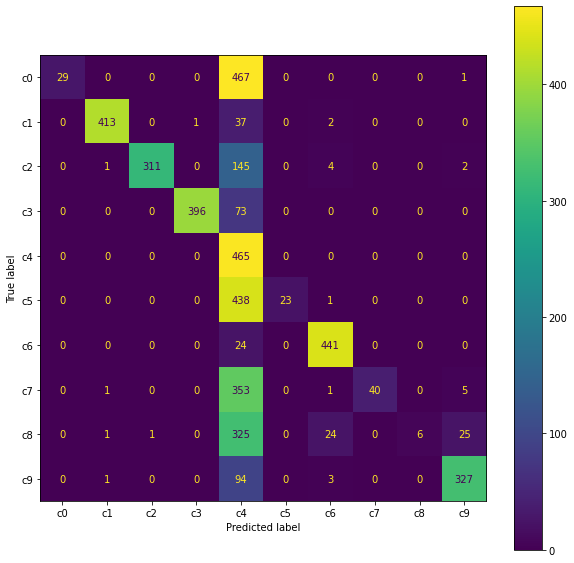

In [56]:
model.fit_model(model.vgg16_3, x_train, y_train, EPOCHS, BATCH_SIZE, VERBOSE)
model.evaluate_model(model.vgg16_3, x_test, y_test, BATCH_SIZE)